# Predict된 Reactant들을 Visualization

In [242]:
import os
import re
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage

In [111]:
exp_dir ='./data/real/'
    
pred_file = os.path.join(exp_dir, 'pred_results_119.txt')

In [112]:
class TreeNode:
    def __init__(self, value, no, smi):
        self.value = value
        self.no = no
        self.smi = smi
        self.children = {}

    def add_child(self, child_node):
        self.children[child_node.value] = child_node

    def print_tree(self, depth=0):
        prefix = "    " * depth
        print(f'{prefix} {self.no} {self.value} {self.smi}')
        for child_value, child_node in self.children.items():
            child_node.print_tree(depth + 1)

In [146]:
product=[]
reactant_process=[]

with open(pred_file, 'r', encoding='UTF8') as fp:

    line = None
    product_mole={}
    
    root = TreeNode('root', 0, '')
    while line !='':
        line = fp.readline()
        
        if 'p:' in line:
            layer_no =''

            no = re.match(r"\((\d+)\)", line)
            prod_no = no.group(1)
            start_index = line.index('p:[')
            smi = line[start_index+2:-1]
            product.append([prod_no, smi])
            
        elif 'pred_layer' in line:
            no = re.search(r"pred_layer(\d+):", line)
            layer_no = no.group(1)
            start_index = line.index('[')
            smi = line[start_index:-1]
            reactant_process.append(['l', prod_no,layer_no,'', smi])
        elif 'react_' in line:
            no = re.match(r"\s*react_l(\d+)_r(\d+):", line)
            layer_no = no.group(1)           
            reactant_no =no.group(2)
            start_index = line.index('[')
            smi = line[start_index:-1]
            reactant_process.append(['r', prod_no,layer_no, reactant_no, smi])


In [251]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
  
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

In [176]:
df_product = pd.DataFrame(product, columns=['product_no', 'product_smi'])
df_reactant = pd.DataFrame(reactant_process, columns=['lr','product_no', 'layer_no','reactant_no','smi'])

In [205]:
df_product['product_smi']

0     [CH3:1][O:2][CH:3]1[CH:4]=[C:5]([CH3:6])[CH2:7...
1     [CH3:1][C:2]1([OH:3])[CH:4]=[CH:5][CH2:6][CH:7...
2     [CH3:1][CH2:2][C:3]1([CH3:4])[CH2:5][O:6][C:7]...
3     [CH3:1][C:2](=[O:3])[C:4](=[O:5])[CH:6]1[CH2:7...
4     [CH3:1][CH2:2][C:3]12[CH2:4][CH:5]1[CH2:6][CH:...
5     [CH3:1][C:2]([OH:3])([C:4]#[N:5])[C:6](=[NH:7]...
6     [CH3:1][CH:2]1[NH:3][C:4]2=[N:5][CH2:6][CH:7](...
7     [CH3:1][CH2:2][CH2:3][NH:4][C:5]([CH3:6])([CH3...
8     [NH:1]=[c:2]1[o:3][n:4][c:5]([OH:6])[n:7][c:8]...
9     [CH3:1][CH2:2][CH:3]([OH:4])[CH2:5][CH2:6][NH:...
10    [CH3:1][CH:2]([OH:3])[C:4](=[O:5])[CH2:6][CH:7...
11    [CH:1]#[C:2][CH:3]([CH2:4][OH:5])[NH:6][C:7]([...
12    [CH3:1][C:2]12[CH:3]=[CH:4][CH:5]([C:6]#[N:7])...
13    [CH:1]#[C:2][C:3]1([CH:4]=[O:5])[CH:6]2[CH2:7]...
14    [CH3:1][CH:2]([C:3]#[C:4][CH:5]=[O:6])[CH:7]=[...
15    [O:1]=[CH:2][C:3]1([OH:4])[CH:5]2[CH2:6][CH2:7...
16    [O:1]=[C:2]1[CH:3]2[CH:4]=[CH:5][CH:6]3[O:7][C...
17    [NH:1]=[C:2]1[O:3][CH2:4][CH:5]2[CH2:6][N:

## Product_no를 가지고 Molecule을 그려보자

8 [NH:1]=[c:2]1[o:3][n:4][c:5]([OH:6])[n:7][c:8]1[OH:9]


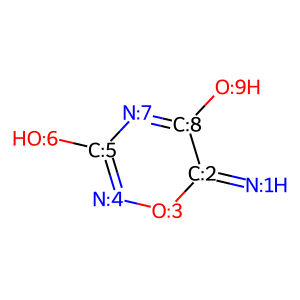

In [287]:
product_no = '8'
this_product = df_product[df_product['product_no']==product_no]
this_df = df_reactant[df_reactant['product_no']== product_no]
product_smi = this_product['product_smi'].iloc[0] 
print(product_no, product_smi)
molecule= Chem.MolFromSmiles(product_smi, sanitize=False)
Draw.MolToImage(molecule)
#Draw.MolToMPL(molecule)

In [288]:
# product_no는 위에서 정의
this_df = df_reactant[df_reactant['product_no']== product_no]
reactant_seq = 0 
reactant_list = []
for i,row in this_df.iterrows():
    lr = row['lr']
    layer_no = row['layer_no']
    reactatnt_no = row['reactant_no']
    smi = row['smi']
    
    if lr=='l':
        print(f"{'    ' * int(layer_no)}level{layer_no} {smi}")
    elif lr=='r':
        reactant_seq +=1
        print(f"{'    ' * (int(layer_no)+1)} ({reactant_seq}) r{reactatnt_no} {smi}")
        reactant_list.append([reactant_seq,smi])

    level1 [CH3:1][O:2][c:3]1[n:4][c:5]([OH:6])[n:7][o:8][c:9]1=[NH:10]
         (1) r1 [CH3:1][O:2][c:3]1[n:4][c:5]([OH:6])[n:7][o:8][c:9]1=[NH:10]
        level2 [CH3:1][OH:2].[NH:3]=[c:4]1[o:5][n:6][c:7]([OH:8])[n:9][c:10]1[Cl:11]
             (2) r1 [CH3:1][OH:2]
             (3) r2 [NH:1]=[c:2]1[o:3][n:4][c:5]([OH:6])[n:7][c:8]1[Cl:9]
            level3 [CH3:1][O:2][c:3]1[n:4][o:5][c:6](=[NH:7])[c:8]([Cl:9])[n:10]1
                 (4) r1 [CH3:1][O:2][c:3]1[n:4][o:5][c:6](=[NH:7])[c:8]([Cl:9])[n:10]1
                level4 [CH3:1][OH:2].[NH:3]=[c:4]1[o:5][n:6][c:7]([Cl:8])[n:9][c:10]1[Cl:11]
                     (5) r1 [CH3:1][OH:2]
                     (6) r2 [NH:1]=[c:2]1[o:3][n:4][c:5]([Cl:6])[n:7][c:8]1[Cl:9]
                    level5 [Cl:1][c:2]1[n:3][o:4][c:5](=[N:6][CH2:7][c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:14]([Cl:15])[n:16]1
                         (7) r1 [Cl:1][c:2]1[n:3][o:4][c:5](=[N:6][CH2:7][c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:14]([Cl:15])[n:16]1


## Product_no에 따라 Reactant 생성된 것을 모두 Visualization

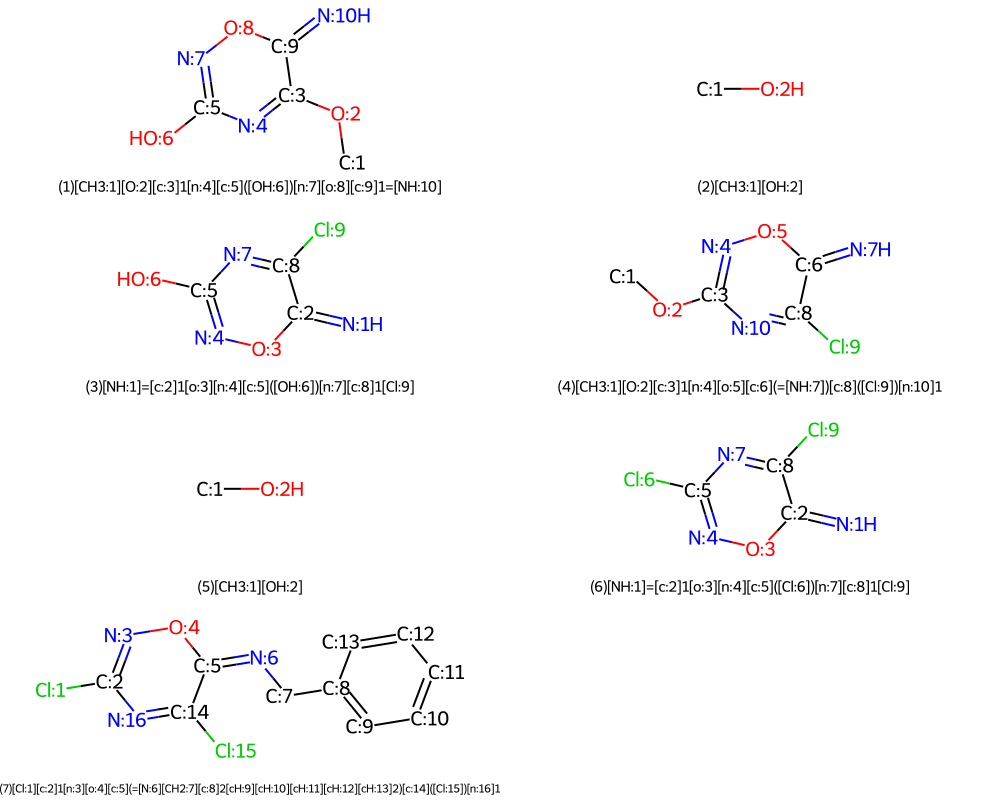

In [289]:
molecules = [molecule_from_smiles(smi[1]) for smi in reactant_list]
legends = [ f"({i[0]}){i[1]}" for i in reactant_list]
MolsToGridImage(molecules, molsPerRow=2, subImgSize=(500, 200), legends=legends, useSVG=True)